# Майнор Интеллектуальный анализ данных / Введение в анализ данных

## Домашнее задание 3. Логистическая регрессия и случайный лес.

В этом задании вам предстоит:
- поработать с логистической регрессией (полная реализация не потребуется, однако можно заработать бонусные баллы)
- воспроизвести подход случайного леса через одно решающее дерево, поэкспериментировать со случайным лесом.

На все вопросы требуется отвечать развёрнуто, аппелируя к полученным значениям или графикам, ответы вписывать в отдельную ячейку, выбрав для неё тип "Markdown". От полноты и качества ответов будет во многом зависеть ваша итоговая оценка.

Задание выполняется самостоятельно, плагиат будет стандартно наказываться лишением всех баллов за задание.
- Максимальная оценка за задание: 10 баллов.
- Дата выдачи: 28.04.2018
- Срок сдачи: 23:59 18.05.2018

In [1]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


## Часть 0. Подготовка данных.

Для наших экспериентов возьмём обучающую выборку [отсюда](https://www.kaggle.com/iabhishekofficial/mobile-price-classification).

In [2]:
train = pd.read_csv('train.csv')

Решается задача многоклассовой классификации — определение ценовой категории телефона. Для простоты перейдём к задаче бинарной классификации — пусть исходные классы 0 и 1 соответствуют классу 0 новой целевой переменной, а остальные классу 1.

Замените целевую переменную, отделите её в отдельную переменную и удалите из исходной выборки.

In [3]:
X = train.iloc[:,:-1]
y = train.iloc[:,-1].replace([0, 1, 2, 3], [0, 0, 1, 1])

Разделите выборку на обучающую и тестовую части в соотношении 7 к 3. Для этого можно использовать `train_test_split` из scikit-learn. Не забудьте зафиксировать сид для разбиения.

In [4]:
from sklearn.model_selection import train_test_split
X_train_ns, X_test_ns, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

## Часть 1. Логистическая регрессия.

[4 балла]

В этой части вы будете обучать самый простой бинарный классификатор — логистическую регрессию. Будем использовать готовую реализацию `LogisticRegression` из scikit-learn.

Логистическая регрессия — линейный метод, то есть в нём предсказание алгоритма вычислаяется как скалярное произведение признаков и весов алгоритма: 

$$
b(x) = w_0 + \langle w, x \rangle = w_0 + \sum_{i=1}^{d} w_i x_i
$$

Для вычисления вероятности положительного класса применяется сигмода. В результате предсказание вероятности принадлежности объекта к положительному классу можно записать как: 

$$
P(y = +1 | x) = \frac{1}{1 + \exp(- w_0 - \langle w, x \rangle )}
$$

Не забывайте, что для линейных методов матрицу объекты-признаки необходимо предварительно нормировать (то есть привести каждый признак к одному и тому же масштабу одним из способов). Для этого можно воспользоваться `StandardScaler` или сделать это вручную.

In [5]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train_ns)

X_train = scaler.transform(X_train_ns)
X_test = scaler.transform(X_test_ns)

Обучите логистическую регрессию. Сделайте предсказания для тестовой части, посчитайте по ним ROC-AUC и Accuracy (порог 0.5). Хорошо ли удаётся предсказывать целевую переменную?

Не забывайте, что метод `predict_proba` вычисляет вероятности обоих классов выборки, а в бинарной классификации нас интересует в первую очередь вероятность принадлежности к положительному классу.

In [6]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred_prob = logreg.predict_proba(X_test)[:,1]

from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(y_test, y_pred_prob)
print("ROC-AUC: %f" % roc_auc)

from sklearn.metrics import accuracy_score
y_pred = np.where(y_pred_prob > 0.5, 1, 0)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %f" % accuracy)

ROC-AUC: 0.999756
Accuracy: 0.986667


>Хорошо ли удаётся предсказывать целевую переменную?
Да. Roc-auc и accuracy высокие.

У обученной логистической регрессии есть два аттрибута: `coef_` и `intercept_`, которые соответствуют весам $w$ и $w_0$. Это и есть результат обучения логистической регрессии. Попробуйте с помощью них (с помощью всё той же обученной ранее логистической регрессии) посчитать "сырое" предсказание алгоритма $b(x)$. 

Постройте гистограмму полученных значений и ответьте на вопросы:
- Какие значения принимает такое предсказание?
- Похожи ли эти значения на вероятность классов?

<function matplotlib.pyplot.show>

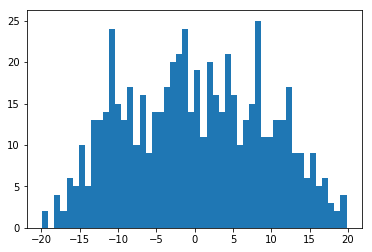

In [7]:
def b(x):
    return logreg.intercept_ + np.dot(logreg.coef_, x)[0]

y_pred_linreg = np.array([b(x) for x in X_test])

plt.hist(y_pred_linreg, bins=50)
plt.show

>Какие значения принимает такое предсказание?
Ненормированные. Значения лежащие на линейной регрессии.
Похожи ли эти значения на вероятность классов?
Нет. Как минимум, потому что некоторые значения отрицательные.

Реализуйте сигмоиду и постройте её график. Что вы можете сказать об этой функции?

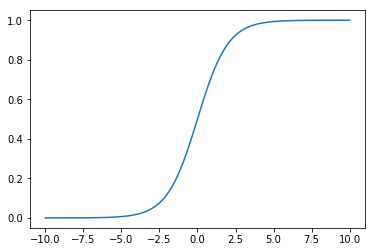

In [8]:
x = np.linspace(-10,10,100)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

plt.plot(x, sigmoid(x))

>Что вы можете сказать об этой функции? Сигмо́ида — это гладкая монотонная нелинейная функция, имеющая форму буквы "S", которая часто применяется для «сглаживания» значений некоторой величины. Возрастающая функция.

Примените реализованную сигмоиду к $b(x)$. Вы должны получить вероятности принадлежности к положительному классу. Проверьте, что ваши значения совпали с теми, которые получены с помощью `predict_proba`.

In [9]:
results = np.array([sigmoid(b(x)) for x in X_test]).flatten()
np.array_equal(float32(results), float32(y_pred_prob)) # without float32 it compares wrongly

True

Таким образом, обучение логистической регрессии — настройка параметров $w$ и $w_0$, а применение — подсчёт вероятностей принадлежности положительному классу как применение сигмоды к скалярному произведению признаков и параметров.

Постройте для обученной логистической регрессии ROC-кривую `roc_curve` и PR-кривую `precision_recall_curve`.

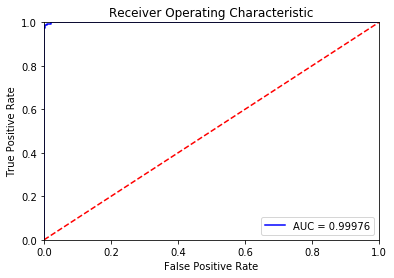

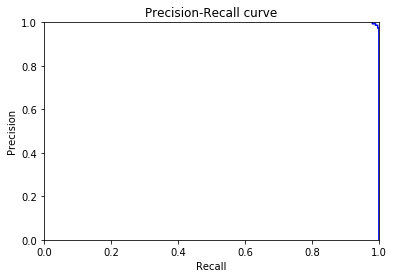

In [10]:
from sklearn.metrics import roc_curve
fpr, tpr, threshold = roc_curve(y_test, y_pred_prob)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.5f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(
    y_test, y_pred_prob)

plt.title('Precision-Recall curve')
plt.plot(precision, recall, 'b')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

### Бонусное задание. Обучение логистической регрессии.

[2 бонусных балла]

Если выше вручную мы только применяли логистическую регрессию, то здесь предлагается реализовать обучение с помощью полного градиентного спуска.

Если кратко, то обучение логистической регрессии с $L_2$-регуляризацией можно записать следующим образом:

$$
Q(w, X) = \frac{1}{l} \sum_{i=1}^{l} \log (1 + \exp(- y_i \langle w, x_i \rangle )) + \frac{\lambda_2}{2} \lVert w \rVert _2^2 \to \min_w
$$

Считаем, что $y_i \in \{-1, +1\}$, а нулевым признаком сделан единичный (то есть $w_0$ соответствует свободному члену). Искать $w$ будем с помощью градиентного спуска:

$$
w^{(k+1)} = w^{(k)} - \alpha \nabla_w Q(w, X)
$$

В случае полного градиентного спуска $\nabla_w Q(w, X)$ считается напрямую (как есть, то есть, используя все объекты выборки). Длину шага $\alpha > 0$ в рамках данного задания предлагается брать равной некоторой малой константе.

Градиент по объекту $x_i$ считается по следующей формуле:

$$
\nabla_w Q(w, x_i) = - \frac{y_i x_i}{1 + \exp(y_i \langle w, x_i \rangle)} + \lambda_2 w
$$

На самом деле неправильно регуляризировать свободный член $w_0$ (то есть при добавлении градиента для $w_0$ не надо учитывать слагаемое с $\lambda_2$). Но в рамках этого задания мы не обращаем на это внимания и работаем со всеми вектором весов одинаково. 

В качестве критерия останова необходимо использовать (одновременно):
- проверку на евклидовую норму разности весов на двух соседних итерациях (например, меньше некоторого малого числа порядка $10^{-6}$) — параметр tolerance
- достижение максимального числа итераций (например, 10000) — параметр max\_iter.

Инициализировать веса можно случайным образом или нулевым вектором.

Реализуйте обучение логистической регрессии. Для удобства ниже предоставлен прототип с необходимыми методами. В `loss_history` необходимо сохранять вычисленное на каждой итерации значение функции потерь. 

In [11]:
from sklearn.base import BaseEstimator

class LogReg(BaseEstimator):
    def __init__(self, lambda_2=1.0, tolerance=1e-4, max_iter=1000, alpha=1e-3):
        """
        lambda_2: L2 regularization param
        tolerance: for stopping gradient descent
        max_iter: maximum number of steps in gradient descent
        alpha: learning rate
        """
        self.lambda_2 = lambda_2
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.alpha = alpha
        self.w = None
        self.loss_history = None
    
    def fit(self, X, y):
        """
        X: np.array of shape (l, d)
        y: np.array of shape (l)
        ---
        output: self
        """
        self.loss_history = []
        
        self.w = np.zeros(X.shape[1])

        for it in range(self.max_iter):
            grad = self.calc_gradient(X, y)
            self.loss_history.append(self.calc_loss(X, y))
            if np.linalg.norm(self.alpha * grad) < self.tolerance:
                break
            self.w -= grad * self.alpha
        
        return self
    
    def predict_proba(self, X):
        """
        X: np.array of shape (l, d)
        ---
        output: np.array of shape (l, 2) where
        first column has probabilities of -1
        second column has probabilities of +1
        """
        if self.w is None:
            raise Exception('Not trained yet')
        
        res = np.array([[1.0-prob, prob] for prob in sigmoid(np.dot(X, self.w))])
        return res
    
    def calc_gradient(self, X, y):
        """
        X: np.array of shape (l, d) (l can be equal to 1 if stochastic)
        y: np.array of shape (l)
        ---
        output: np.array of shape (d)
        """
        res = np.dot(-X.T, y / (1 + np.exp(y * np.dot(X, self.w)))) / X.shape[0] + self.lambda_2 * self.w
        return res

    def calc_loss(self, X, y):
        """
        X: np.array of shape (l, d)
        y: np.array of shape (l)
        ---
        output: float 
        """ 
        res = np.mean(np.log(1 + np.exp(-y * (np.dot(X, self.w))))) + self.lambda_2/2 * np.dot(self.w, self.w)
        return res

1. Примените логистическую регрессию на той же выборке.
2. Посчитайте качество по тем же метрикам.
3. Визуализируйте изменение значений функции потерь от номера итераций.

ROC-AUC: 0.995711
Accuracy: 0.960000


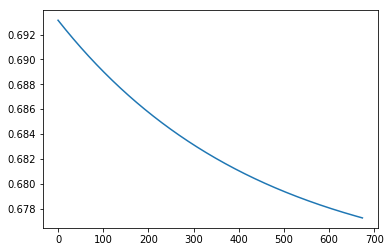

In [12]:
logreg2 = LogReg(max_iter=10000)
logreg2.fit(X_train, y_train)
y_pred_prob2 = logreg2.predict_proba(X_test)[:,1]

roc_auc2 = roc_auc_score(y_test, y_pred_prob2)
print("ROC-AUC: %f" % roc_auc2)

y_pred2 = np.where(y_pred_prob2 > 0.5, 1, 0)
accuracy = accuracy_score(y_test, y_pred2)
print("Accuracy: %f" % accuracy)

plt.plot(logreg2.loss_history)
plt.show()

## Часть 2. Случайные леса.

[6 баллов]

Случайный лес — алгоритм машинного обучения, представляющий собой бэггинг над решающими деревьями (усреднение ответов множества слабых алгоритмов) с 2 основными идеями:
- Использование подмножества признаков при построении каждого сплита дерева.
- Бутстрап обучающей выборки для построения каждого дерева (с повторениями).

В этом задании мы попробуем оценить пользу каждой из идей. Будем использовать ту же выборку с тем же разбиением на 2 части. Для начала обучите решающее дерево `DecisionTreeClassifier` из scikit-learn и посчитайте ROC-AUC и Accuracy (порог 0.5). Не забудьте зафикиксировать сид для построения дерева (несмотря на то, что в классической реализации никакой случайности нет, при большой глубине дерева может возникать неоднозначность в выборке признака в сплите). Используйте этот сид для всех заданий ниже.

In [13]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(random_state=42)
dtc.fit(X_train, y_train)
y_pred = dtc.predict_proba(X_test)[:,1]

roc_auc = roc_auc_score(y_test, y_pred)
print("ROC-AUC: %f" % roc_auc)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %f" % accuracy)

ROC-AUC: 0.936594
Accuracy: 0.936667


### 2.1 Бэггинг классификаторов

Реализуйте бэггинг над решающими деревьями (усреднение предсказанных вероятностей всего ансамбля). 
В качестве основы используйте всё тот же `DecisionTreeClassifier`. Количество базовых алгоритмов предлагается брать равным 100. 

Посчитайте качество с помощью тех же метрик. Ответьте на следующие вопросы:
- Что интересного вы видите?
- С чем это связано?

In [14]:
np.random.seed(123)

train_size = X_train.shape[0]
test_size = X_test.shape[0]

dtc = DecisionTreeClassifier()

numberOfTrees = 100

res = np.zeros(test_size)
for i in range(numberOfTrees):
    ind = np.random.choice(np.arange(train_size), size=train_size, replace=False)
    y_arr = np.array(y_train)
    dtc.fit(X_train[ind], y_arr[ind])
    res += dtc.predict_proba(X_test)[:,1]

y_pred_prob = res / numberOfTrees

roc_auc = roc_auc_score(y_test, y_pred_prob)
print("ROC-AUC: %f" % roc_auc)

y_pred = np.where(y_pred_prob > 0.5, 1, 0)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %f" % accuracy)

ROC-AUC: 0.957396
Accuracy: 0.948333


>Что интересного вы видите? Качество улучшилось. Беггинг улучшает качество.
С чем это связано? С тем что мы обучаем множество деревьев и усредняем их ответы.

### 2.2 Сэмплирование обучающей выборки

Добавим к нашему бэггингу бутстрап выборки (генерация случайной выборки того же размера с возвращением). Для этого может пригодиться `numpy.random.randint`.

Посчитайте качество. Что вы видите?

In [15]:
np.random.seed(123)  # для одинакового бутстрапа в каждом запуске

dtc = DecisionTreeClassifier()

res = np.zeros(test_size)
for i in range(numberOfTrees):
    ind = np.random.choice(np.arange(train_size), size=train_size, replace=True)
    y_arr = np.array(y_train)
    dtc.fit(X_train[ind], y_arr[ind])
    res += dtc.predict_proba(X_test)[:,1]

y_pred_prob = res / numberOfTrees

roc_auc = roc_auc_score(y_test, y_pred_prob)
print("ROC-AUC: %f" % roc_auc)

y_pred = np.where(y_pred_prob > 0.5, 1, 0)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %f" % accuracy)

ROC-AUC: 0.993122
Accuracy: 0.966667


> Что вы видите? Качество стало совсем хорошим. Бутстрап улучшает качество.

### 2.3 Выбор случайного подмножества признаков

Временно забудем о бутстрапе выборки и добавим выбор случайного подмножества признаков при построении каждого сплита. В `DecisionTreeClassifier` за это отвечает параметр `max_features`. По умолчанию он имеет значение `None`, что обозначает использование всех возможных признаков. Для задачи классификации рекоменуется использовать квадратный корень от количества признаков. Попробуйте выставить такое значение. На этот раз надо отключить фиксированный сид в построении дерева, так как иначе каждый раз мы будем выбирать одинаковые подмножества признаков. 

Посчитайте качество. Что вы видите?

In [16]:
np.random.seed(123)  # для воспроизводимости построения случайных подмножеств признаков

dtc = DecisionTreeClassifier(max_features='sqrt')

res = np.zeros(test_size)

for i in range(numberOfTrees):
    y_arr = np.array(y_train)
    dtc.fit(X_train, y_arr)
    res += dtc.predict_proba(X_test)[:,1]

y_pred_prob = res / numberOfTrees
roc_auc = roc_auc_score(y_test, y_pred_prob)
print("ROC-AUC: %f" % roc_auc)

y_pred = np.where(y_pred_prob > 0.5, 1, 0)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %f" % accuracy)

ROC-AUC: 0.992238
Accuracy: 0.958333


> Что вы видите? Качество лучше чем у обычного беггинга. Выбор случайного подмножества признаков улучшает качество.

### 2.4 = 2.2 + 2.3

Объединим два подхода (бутстрап + выбор подмножества признаков). Получим случайный лес.

Посчитайте качество. Что вы видите?

In [17]:
np.random.seed(123)  # для одинакового бутстрапа и выбора подмножеств признаков в каждом запуске

dtc = DecisionTreeClassifier(max_features='sqrt')

res = np.zeros(test_size)
for i in range(numberOfTrees):
    ind = np.random.choice(np.arange(train_size), size=train_size, replace=True)
    y_arr = np.array(y_train)
    dtc.fit(X_train[ind], y_arr[ind])
    res += dtc.predict_proba(X_test)[:,1]

y_pred_prob = res / numberOfTrees
roc_auc = roc_auc_score(y_test, y_pred_prob)
print("ROC-AUC: %f" % roc_auc)

y_pred = np.where(y_pred_prob > 0.5, 1, 0)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %f" % accuracy)

ROC-AUC: 0.992960
Accuracy: 0.958333


> Что вы видите? Качество стало еще чуть лучше. бутстрап + выбор подмножества признаков = <3

То, что мы сделали уже реализовано в `RandomForestClassifier`. Попробуйте воспользоваться им. Количество используемых деревьев передаётся в параметре `n_estimators`.

Посчитайте качество. Что вы видите?

In [18]:
np.random.seed(123) 

from sklearn.ensemble import RandomForestClassifier
clf_r = RandomForestClassifier(n_estimators=100, max_features='sqrt')
clf_r.fit(X_train, y_train)
y_pred_prob = clf_r.predict_proba(X_test)[:,1]

roc_auc = roc_auc_score(y_test, y_pred_prob)
print("ROC-AUC: %f" % roc_auc)

y_pred = np.where(y_pred_prob > 0.5, 1, 0)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %f" % accuracy)

ROC-AUC: 0.993633
Accuracy: 0.955000


> Что вы видите? Качество примерно как у нас.

### 2.5 Влияние количества используемых деревьев в случайном лесе

Один из параметров случайного леса — количество деревьев, используемых в бэггинге. Оценим, как влияет этот параметр на финальное качество. Для этого обучите случайные леса с разным количество деревьев (например, перебирайте от 10 до 1000 с шагом в 10), оцените качество с помощью ROC-AUC. Постройте график зависимости ROC-AUC от количества используемых деревьев. Что вы видите?

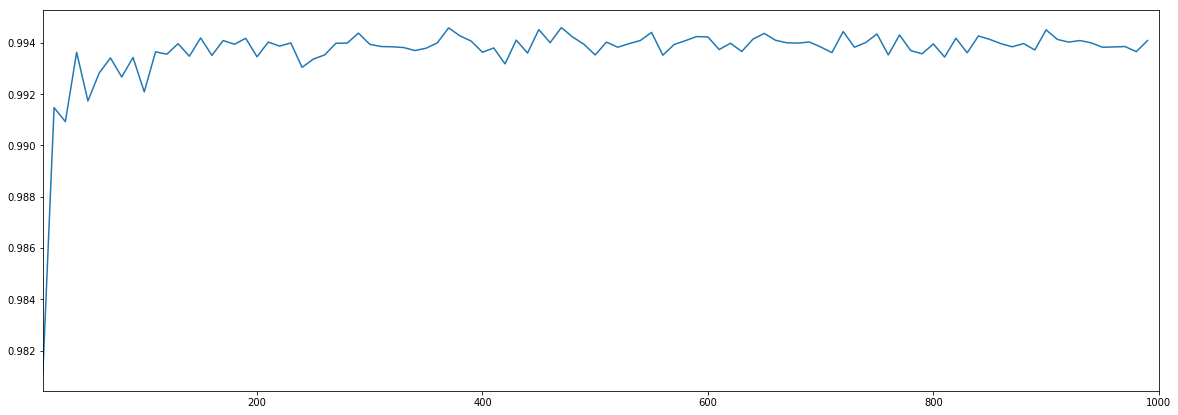

In [19]:
estimators = np.arange(10,1000,10)
scores = []

for e in estimators:
    clf_r = RandomForestClassifier(n_estimators=e)
    clf_r.fit(X_train, y_train)
    y_pred_prob = clf_r.predict_proba(X_test)[:,1]
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    scores.append(roc_auc)
    
from pylab import rcParams
rcParams['figure.figsize'] = 20, 7

plt.plot(estimators, scores)
plt.xlim(xmin=10, xmax=1000)
plt.show()

> Что вы видите? После ~100 деревьев качество не меняется. 

### 2.6 Важность признаков

Случайный лес позволяет оценить важность признаков. У обученного случайного леса есть аттрибут `feature_importances_`, где храниться важность для каждого признака. Постройте `barplot` с важностью признаков (удобно использовать библиотеку `seaborn`, где можно для каждого столбца передать название признака `train.columns`).

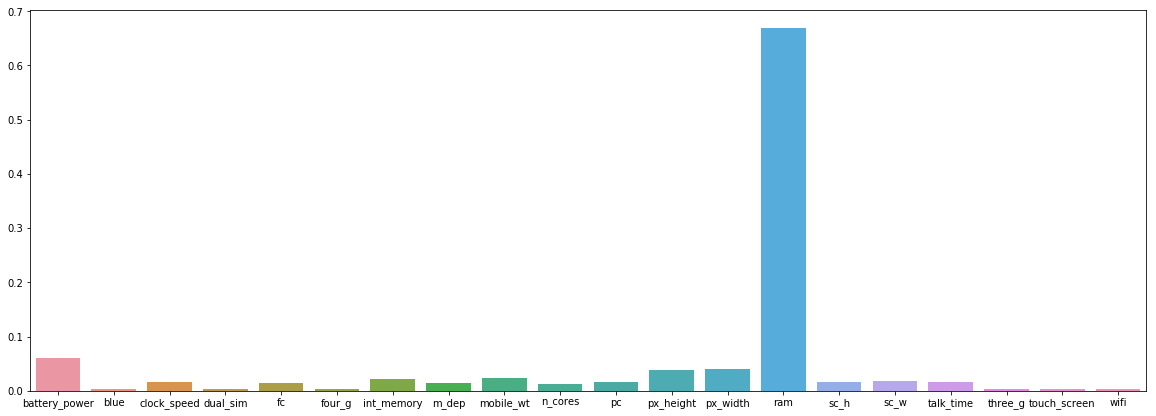

In [20]:
import seaborn as sns

imp = clf_r.feature_importances_ 
sns.barplot(x = train.columns[:-1], y = imp)

## Выводы

Напишите, что интересного вы узнали в этой работе, в каких экспериментах какие результаты получились.


> Для задачи классификации мы не можем использовать линейную регрессию, используем логистическую. Для этого используем сигмоиду, гладкую функцию. Обычная логистическая регрессия показала качество лучшее чем у случайного леса. Использование ансамбля вместо 1 дерева, использование беггинга, бустрапа, выбор случайного подможества признаков повышают качество предсказаний. Случайный лес показал высокое качество. После ~100 деревьев случайный лес не показывает значимого изменения в качестве. Оперативная память - определяющий признак в предсказывании ценовой категории смартфона.